In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Subset
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [2]:
from typing import Any
import pytorch_lightning as pl
from torchmetrics.functional import accuracy

class ResNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.do = nn.Dropout(0.1)

        self.loss = nn.CrossEntropyLoss()

    def forward(self,x):
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        do = self.do(h2 + h1)  #dropout
        logits = self.l3(do)
        return logits
    
    def prepare_data(self):
        
        MNIST('', train = True, download=True)
        MNIST('', train = False, download=True)

        
    def setup(self,stage = None):
        # 准备数据集
        transform = transforms.ToTensor()
        dataset = MNIST('', train=True, transform=transform)
        dataset_predict = MNIST('', train=False, transform=transform)
        self.train_m, self.val = random_split(dataset, [55000, 5000])

        self.mnist_test = MNIST('', train=False, transform=transform)

        self.mnist_predict = Subset(dataset_predict, list(range(5)))  #将predict的集合缩减为5个样本
    
    def train_dataloader(self): 
        train_loader = DataLoader(self.train_m, batch_size=32)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.val, batch_size=32)
        return val_loader
    
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=32)
    
    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, batch_size=1)
    
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr = 1e-2)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch  
        
        #x为图像 batch*1*28*28,y为label.
        #将x拉直，batch*(28*28)  
        x = x.view(x.size(0),-1)

        #1 forward
        logit = model(x)
        # import pdb; pdb.set_trace()    调试方法，添加断点

        #2 compute the objective function
        J = self.loss(logit,y)

        acc = accuracy(logit.softmax(dim=-1), y, task='multiclass', num_classes=10)
        pbar = {'train_acc':acc}

        return {'loss': J,'progress_bar':pbar}
    

    #使用train_step进行验证
    def validation_step(self, batch, batch_idx):
        results = self.training_step(batch, batch_idx)
        self.log('val_loss',results['loss'], prog_bar=True)
        self.log('val_acc',results['progress_bar']['train_acc'])
        return results
    
    #在每次循环结束后计算其损失以及准确率
    
    def on_validation_epoch_end(self):
        avg_val_loss = self.trainer.callback_metrics['val_loss'].item()
        avg_val_acc = self.trainer.callback_metrics['val_acc'].item()
        print("Validation epoch ended.")
        
        print(f"Mean validation loss: {avg_val_loss:.4f}")

        print(f"Mean validation accuracy: {avg_val_acc:.4f}")

    def test_step(self, batch, batch_idx):
        results = self.training_step(batch, batch_idx)
        results['progress_bar']['test_acc'] = results['progress_bar']['train_acc']
        self.log('test_loss',results['loss'], prog_bar=True)
        self.log('test_acc',results['progress_bar']['test_acc'])
        return results
    
    def on_test_epoch_end(self):
        avg_test_loss = self.trainer.callback_metrics['test_loss'].item()
        avg_test_acc = self.trainer.callback_metrics['test_acc'].item()
        print("test epoch ended.")
        
        print(f"Mean test loss: {avg_test_loss:.4f}")

        print(f"Mean test accuracy: {avg_test_acc:.4f}")
    
    def predict_step(self, batch, batch_idx):
        x,_ = batch
        logits = self(x.view(-1, 28 * 28))
        preds = logits.softmax(dim=-1)
        print(f'预测结果：{preds}')
        return preds
        # self.log('prediction', preds) predict_step中不能使用self.log()函数
        
    #predict中outouts还是可用的,注意转移到cpu计算。将 CUDA 张量转换为 NumPy 数组时会出现的问题
    def on_predict_batch_end(self, outputs,batch, batch_idx):
        x,_ = batch
        prediction = outputs.cpu().argmax(dim=1)
        plt.figure()
        plt.imshow(x[0].cpu().view(28, 28))
        plt.title("    "+"prediction: " +str(int(prediction)))
        plt.show()
        
    
    
        
    
model = ResNet()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\learningsoft\envs\pytorch_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

d:\learningsoft\envs\pytorch_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 10.99it/s]Validation epoch ended.
Mean validation loss: 2.3230
Mean validation accuracy: 0.1562


d:\learningsoft\envs\pytorch_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1719/1719 [00:13<00:00, 131.45it/s, v_num=16]Validation epoch ended.
Mean validation loss: 0.4007
Mean validation accuracy: 0.8876
Epoch 1: 100%|██████████| 1719/1719 [00:15<00:00, 111.17it/s, v_num=16, val_loss=0.401]Validation epoch ended.
Mean validation loss: 0.3246
Mean validation accuracy: 0.9076
Epoch 2: 100%|██████████| 1719/1719 [00:13<00:00, 131.82it/s, v_num=16, val_loss=0.325]Validation epoch ended.
Mean validation loss: 0.2815
Mean validation accuracy: 0.9196
Epoch 3: 100%|██████████| 1719/1719 [00:13<00:00, 128.71it/s, v_num=16, val_loss=0.281]Validation epoch ended.
Mean validation loss: 0.2496
Mean validation accuracy: 0.9272
Epoch 4: 100%|██████████| 1719/1719 [00:13<00:00, 126.40it/s, v_num=16, val_loss=0.250]Validation epoch ended.
Mean validation loss: 0.2265
Mean validation accuracy: 0.9322
Epoch 4: 100%|██████████| 1719/1719 [00:14<00:00, 116.96it/s, v_num=16, val_loss=0.226]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1719/1719 [00:14<00:00, 116.91it/s, v_num=16, val_loss=0.226]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\learningsoft\envs\pytorch_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 179.92it/s]test epoch ended.
Mean test loss: 0.1965
Mean test accuracy: 0.9415
Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 178.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9415000081062317
        test_loss           0.19652608036994934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\learningsoft\envs\pytorch_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]预测结果：tensor([[6.4732e-04, 7.4420e-07, 1.4797e-03, 3.6956e-03, 2.5584e-07, 4.0831e-04,
         9.9397e-08, 9.9329e-01, 1.1003e-05, 4.6262e-04]], device='cuda:0')
Predicting DataLoader 0:  20%|██        | 1/5 [00:00<00:00, 16.86it/s]

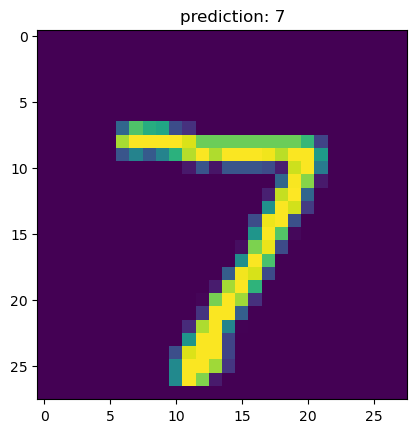

预测结果：tensor([[6.1244e-04, 1.1622e-04, 9.9268e-01, 2.5574e-03, 6.6121e-08, 1.6740e-03,
         1.7936e-03, 1.6604e-06, 5.6743e-04, 3.7320e-08]], device='cuda:0')
Predicting DataLoader 0:  40%|████      | 2/5 [00:00<00:00, 12.02it/s]

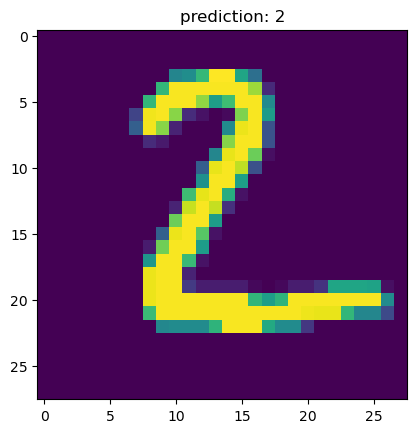

预测结果：tensor([[4.0666e-06, 9.8625e-01, 2.8763e-03, 1.2531e-03, 5.2598e-04, 1.7806e-03,
         1.4055e-03, 3.1162e-03, 2.6221e-03, 1.6788e-04]], device='cuda:0')
Predicting DataLoader 0:  60%|██████    | 3/5 [00:00<00:00, 11.55it/s]

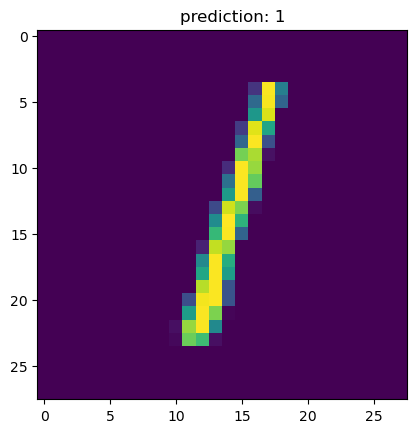

预测结果：tensor([[9.9844e-01, 1.7102e-08, 5.7020e-04, 4.7490e-05, 6.9342e-08, 7.7764e-04,
         3.2800e-05, 5.2667e-05, 3.5639e-05, 4.1717e-05]], device='cuda:0')
Predicting DataLoader 0:  80%|████████  | 4/5 [00:00<00:00, 11.74it/s]

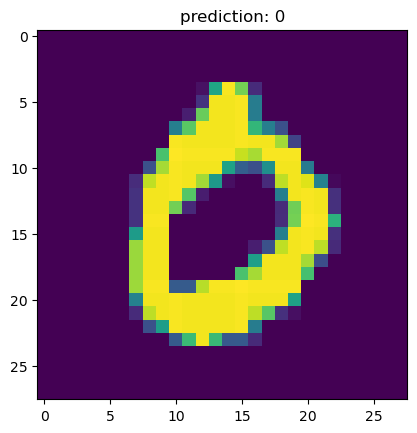

预测结果：tensor([[2.3058e-04, 3.8043e-05, 4.6356e-03, 8.7207e-05, 9.4623e-01, 2.4675e-04,
         3.9733e-03, 5.8444e-03, 1.3406e-03, 3.7369e-02]], device='cuda:0')
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

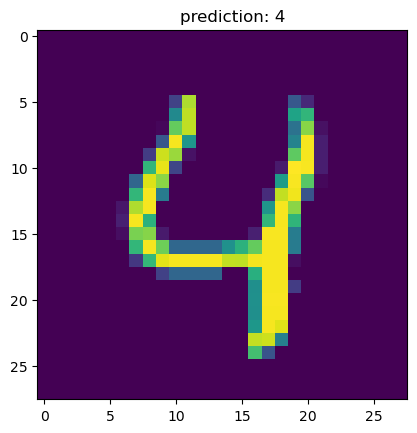

Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00,  9.97it/s]


[tensor([[6.4732e-04, 7.4420e-07, 1.4797e-03, 3.6956e-03, 2.5584e-07, 4.0831e-04,
          9.9397e-08, 9.9329e-01, 1.1003e-05, 4.6262e-04]]),
 tensor([[6.1244e-04, 1.1622e-04, 9.9268e-01, 2.5574e-03, 6.6121e-08, 1.6740e-03,
          1.7936e-03, 1.6604e-06, 5.6743e-04, 3.7320e-08]]),
 tensor([[4.0666e-06, 9.8625e-01, 2.8763e-03, 1.2531e-03, 5.2598e-04, 1.7806e-03,
          1.4055e-03, 3.1162e-03, 2.6221e-03, 1.6788e-04]]),
 tensor([[9.9844e-01, 1.7102e-08, 5.7020e-04, 4.7490e-05, 6.9342e-08, 7.7764e-04,
          3.2800e-05, 5.2667e-05, 3.5639e-05, 4.1717e-05]]),
 tensor([[2.3058e-04, 3.8043e-05, 4.6356e-03, 8.7207e-05, 9.4623e-01, 2.4675e-04,
          3.9733e-03, 5.8444e-03, 1.3406e-03, 3.7369e-02]])]

In [3]:
'''train_data = datasets.MNIST('data', train = True, transform = transforms.ToTensor() )
train, val = random_split(dataset=train_data, lengths=[55000, 5000])#55000个训练集和5000个验证集（随机划分）
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)'''
# 检查是否有可用的 GPU
if torch.cuda.is_available():
    accelerator = 'gpu'
    devices = 1  # 你可以指定多个 GPU，例如 devices=2 或 devices=[0,1]
else:
    accelerator = 'cpu'
    devices = 1

# 创建 Trainer 并在 GPU 上训练
trainer = pl.Trainer(max_epochs=5, accelerator=accelerator, devices=devices)
trainer.fit(model)

# 在测试集上测试模型
trainer.test(model)

# 使用模型进行预测
trainer.predict(model)

